In [2]:
import pandas as pd
import numpy as np
import math, os, sys
import time

import seaborn as sns
import matplotlib.pyplot as plt

from functools import partial

sys.path.insert(0, r"C:\Users\M1049231\Dev\Equifax")
from utils import efx_utils

sns.set_style(style="darkgrid")
sns.set_context("notebook")
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    f1_score,
)

import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
def _get_oversampled_ds(n=2):
    actifact = efx_utils._load_all()
    FEAT = actifact["FINAL_FEAT_V2"]
    
    df = pd.DataFrame(actifact["X"][FEAT], columns=FEAT)
    df['y'] = actifact["y"]
    print("original dataset : ",df.shape)
    df2 = df[df.y == 1]
    for i in range(n):
        df = pd.concat([df,df2],ignore_index = True)
    print("oversampled dataset :  ",df.shape)
    X = df[FEAT].values
    y = df['y'].values
    return (X,y)

In [16]:
def get_dataset(oversample=False,*args,**kwargs):
    actifact = efx_utils._load_all()
    FEAT = actifact["FINAL_FEAT_V2"]
    # FEAT.remove("HAS_DEFAULT")
    
    if oversample:
        (X,y) = _get_oversampled_ds(*args,**kwargs)
    else:
        X = actifact["X"][FEAT].values
        y = actifact["y"]
    
    return _make_dataset(X,y)

def _make_dataset(X,y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.FloatTensor(y_train)
    y_test = torch.FloatTensor(y_test)

    y_test = y_test.reshape(-1, 1)
    y_train = y_train.reshape(-1, 1)
    print("ytrain shape : ",y_train.shape)
    
    return (X_train, X_test, y_train, y_test)

In [15]:
def get_config(input, res: dict=dict(), epochs=10, lr=0.0001, activation="sig"):
    """configurations of the nn model"""

    if "config" not in res.keys():
        config = dict(
            input=input, output=1, lr=lr, epochs=epochs, activation=activation
        )
    else:
        config = res["config"]

    return config

In [39]:
class Linear_Model(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.fc1 = nn.Linear(cfg["input"], cfg["output"],bias = False)
        print(f"using {self.cfg['activation']} activation ")

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
#         x = self.fc1(x)
        x = torch.sigmoid(x)
#         x = nn.BCEWithLogitsLoss(x)
        return x
    
    def predict(self, X_test, y_test):
        
        with torch.no_grad():
            model.eval()
            y_pred = self(X_test).detach().numpy().round()
            assert y_pred.shape == y_test.shape, f"shape not good y_pred.shape {y_pred.shape} y_test.shape {y_test.shape} "
            acc = round(accuracy_score(y_test, y_pred), 3)
            model.train()
        
        return acc

In [33]:
class Model(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.fc1 = nn.Linear(cfg["input"], 2* cfg["input"],bias = True)
        self.fc2 = nn.Linear(2*cfg["input"],  cfg["output"],bias = True)
        print(f"using {self.cfg['activation']} activation : conf using relu +sig + bia")

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
#         x = self.fc1(x)
#         x = self.fc2(x)
        x = torch.sigmoid(x)
        return x
    
    def predict(self, X_test, y_test):
        
        with torch.no_grad():
            model.eval()
            y_pred = self(X_test).detach().numpy().round()
            assert y_pred.shape == y_test.shape, f"shape not good y_pred.shape {y_pred.shape} y_test.shape {y_test.shape} "
            acc = round(accuracy_score(y_test, y_pred), 3)
            model.train()
        
        return acc

In [17]:
X_train, X_test, y_train, y_test = get_dataset(oversample=True,n=2)

files being loaded are :  ['FINAL_FEAT.pkl', 'FINAL_FEAT_V2.pkl', 'X.pkl', 'y.pkl']
files being loaded are :  ['FINAL_FEAT.pkl', 'FINAL_FEAT_V2.pkl', 'X.pkl', 'y.pkl']
original dataset :  (30000, 27)
oversampled dataset :   (43272, 27)
ytrain shape :  torch.Size([34617, 1])


In [44]:
efx_utils._save(df = y_test, prefix ="y_test", loc=r"C:\Users\M1049231\Dev\Equifax\Models\artifacts_train")

using sig activation 
criteria :  BCEWithLogitsLoss 
 Model information : 
 Model(
  (fc1): Linear(in_features=26, out_features=52, bias=True)
  (fc2): Linear(in_features=52, out_features=1, bias=True)
)
At epoch : 0  loss is : 0.7323343753814697   Accuracy : 70.39999999999999 %
At epoch : 10  loss is : 0.732327938079834   Accuracy : 70.0 %
At epoch : 20  loss is : 0.7323281168937683   Accuracy : 70.19999999999999 %
At epoch : 30  loss is : 0.7323341369628906   Accuracy : 70.19999999999999 %
At epoch : 40  loss is : 0.732329785823822   Accuracy : 70.1 %
At epoch : 50  loss is : 0.7323317527770996   Accuracy : 70.1 %
At epoch : 60  loss is : 0.7323310971260071   Accuracy : 70.1 %
At epoch : 70  loss is : 0.7323330044746399   Accuracy : 70.1 %
At epoch : 80  loss is : 0.7323315739631653   Accuracy : 70.19999999999999 %
At epoch : 90  loss is : 0.7323303818702698   Accuracy : 70.1 %
At epoch : 100  loss is : 0.732332706451416   Accuracy : 70.19999999999999 %
At epoch : 110  loss is : 0.73

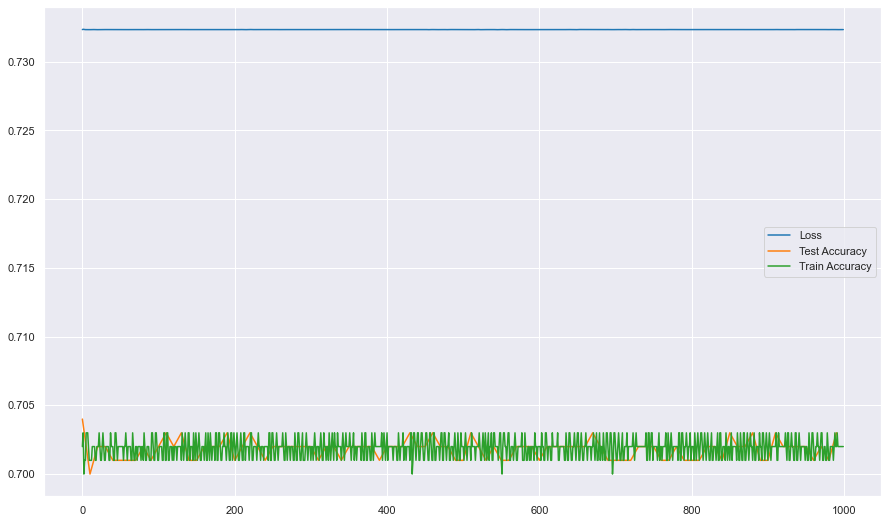

In [40]:
config = get_config(input = X_train.shape[1], epochs=1000, lr=0.001)
L_model = Linear_Model(cfg=config)
res_relu = train_model(model, X_train, X_test, y_train, y_test)

In [454]:
X_train, X_test, y_train, y_test = get_dataset(oversample=True,n=1)
config = get_config(actifact, X_train.shape[1], epochs=1000, lr=0.001)
model = Model(cfg=config)
res_relu = train_model(model, X_train, X_test, y_train, y_test)

files being loaded are :  ['FINAL_FEAT.pkl', 'FINAL_FEAT_V2.pkl', 'X.pkl', 'y.pkl']
files being loaded are :  ['FINAL_FEAT.pkl', 'FINAL_FEAT_V2.pkl', 'X.pkl', 'y.pkl']
original dataset :  (30000, 27)
oversampled dataset :   (36636, 27)
using sig activation : conf using relu +sig + bia
criteria :  BCEWithLogitsLoss 
 Model information : 
 Model(
  (fc1): Linear(in_features=26, out_features=52, bias=True)
  (fc2): Linear(in_features=52, out_features=1, bias=True)
)
At epoch : 0  loss is : 0.7929581999778748   Accuracy : 63.800000000000004 %
At epoch : 10  loss is : 0.7929491996765137   Accuracy : 63.800000000000004 %
At epoch : 20  loss is : 0.7929491400718689   Accuracy : 63.800000000000004 %
At epoch : 30  loss is : 0.7929491400718689   Accuracy : 63.800000000000004 %
At epoch : 40  loss is : 0.7929491400718689   Accuracy : 63.800000000000004 %
At epoch : 50  loss is : 0.7929491400718689   Accuracy : 63.800000000000004 %
At epoch : 60  loss is : 0.7929491400718689   Accuracy : 63.80000

At epoch : 980  loss is : 0.7929491400718689   Accuracy : 63.800000000000004 %


KeyboardInterrupt: 

In [37]:
len(model.fc1.weight.data.detach().numpy())

52

In [24]:
# def get_imp(model):
actifact = efx_utils._load_all()
FEAT = actifact["FINAL_FEAT_V2"]
_ = pd.DataFrame(model.fc1.weight.data.detach().numpy().reshape(-1,1),columns = ['w'])
_['feat'] = FEAT
_.sort_values('w',ascending = False)

# get_imp(model)

files being loaded are :  ['FINAL_FEAT.pkl', 'FINAL_FEAT_V2.pkl', 'X.pkl', 'y.pkl']


ValueError: Length of values (26) does not match length of index (1352)

$$
\text{Technical Learings: TL;DR } \\

$$
$$
\text{1- structure} \\
output = model.forward(X) \\
loss = criterian(output, Y) \\

optim.zero_grad() \\
loss.backward() \\
optim.step() \\
$$
$$
\text{2- finds} \\
\text{the criterian defines the loss funtion to be used and that can be imported from nn.functional as F} \\
\text{for binary classification i use BCEloss() and for categorical others like categorical CE loss}\\
"""https://pytorch.org/docs/stable/nn.functional.html"""
$$

In [11]:
#

In [10]:
def show_results(res_):
    fig, ax = plt.subplots(
        figsize=(15, 9),
    )
    sns.lineplot(
        x=[i for i in range(len(res_["loss_li"]))], y=np.array(res_["loss_li"]), ax=ax
    )
    sns.lineplot(
        x=[i for i in range(len(res_["loss_li"])) if i % 10 == 0],
        y=res_["accuracy_test"],
        ax=ax,
    )
    sns.lineplot(
        x=[i for i in range(len(res_["loss_li"]))], y=res_["accuracy_train"], ax=ax
    )
    plt.legend(["Loss", "Test Accuracy", "Train Accuracy"], loc="center right")
    # plt.show()

In [19]:
def train_model(model, X_train, X_test, y_train, y_test):
    print("criteria :  BCEWithLogitsLoss \n","Model information : \n",model)
    criterian = nn.BCEWithLogitsLoss()  # nn.CrossEntropyLoss()
    config = model.cfg
    model.cfg['time'] = time.time()
    optim = torch.optim.Adam(model.parameters(), lr=config["lr"], weight_decay=1e-3)

    epochs = config["epochs"]
    loss_li = []
    accuracy_test = []
    accuracy_train = []
    for i in range(epochs):

        output = model.forward(X_train)

        loss = criterian(output, y_train)
        
        loss_li.append(loss.detach().numpy())

        acc = round(accuracy_score(y_train.detach().numpy(), output.detach().numpy().round()), 3)
        accuracy_train.append(acc)

        optim.zero_grad()
        loss.backward()
        optim.step()

        if i % 10 == 0:
            acc = model.predict(X_test, y_test)
            print(f"At epoch : {i}  loss is : {loss}   Accuracy : {acc*100} %")
            accuracy_test.append(acc)

    logs = {
        "loss_li": loss_li,
        "accuracy_test": accuracy_test,
        "accuracy_train": accuracy_train,
    }

    
    y_pred = model(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test.detach().numpy(),
                                      np.where(y_pred.detach().numpy()>0.5,1,0)).ravel()
    print(f"tn : {tn}\nfn [type 2 error] : {fn} \nfp [type 1 error]  : {fp}\ntp : {tp}")
    print("Model accuracy : ",round((tp+tn)/(tn+fn+tp+fp),3))
    print("time taken per epoch : ",round((time.time() - model.cfg["time"]), 3), " sec")
    show_results(logs)
    
    return logs

In [101]:
#

In [53]:
#

In [187]:
torch.FloatTensor(pos_y_test.values).shape

torch.Size([1327, 1])

# V1

At epoch : 0  loss is : 0.6583642363548279   Accuracy : 64.5 %
At epoch : 10  loss is : 0.6267842054367065   Accuracy : 73.5 %
At epoch : 20  loss is : 0.6003497838973999   Accuracy : 77.3 %
At epoch : 30  loss is : 0.5788414478302002   Accuracy : 77.8 %
At epoch : 40  loss is : 0.5617004632949829   Accuracy : 77.9 %
At epoch : 50  loss is : 0.5482582449913025   Accuracy : 77.9 %
At epoch : 60  loss is : 0.5377975106239319   Accuracy : 77.9 %
At epoch : 70  loss is : 0.5296478867530823   Accuracy : 77.9 %
At epoch : 80  loss is : 0.523238480091095   Accuracy : 77.9 %
At epoch : 90  loss is : 0.5181121230125427   Accuracy : 77.9 %
At epoch : 100  loss is : 0.5139188766479492   Accuracy : 77.9 %
At epoch : 110  loss is : 0.5103995203971863   Accuracy : 77.9 %
At epoch : 120  loss is : 0.5073673129081726   Accuracy : 77.9 %
At epoch : 130  loss is : 0.5046905279159546   Accuracy : 77.9 %
At epoch : 140  loss is : 0.5022774934768677   Accuracy : 77.9 %
At epoch : 150  loss is : 0.500065505

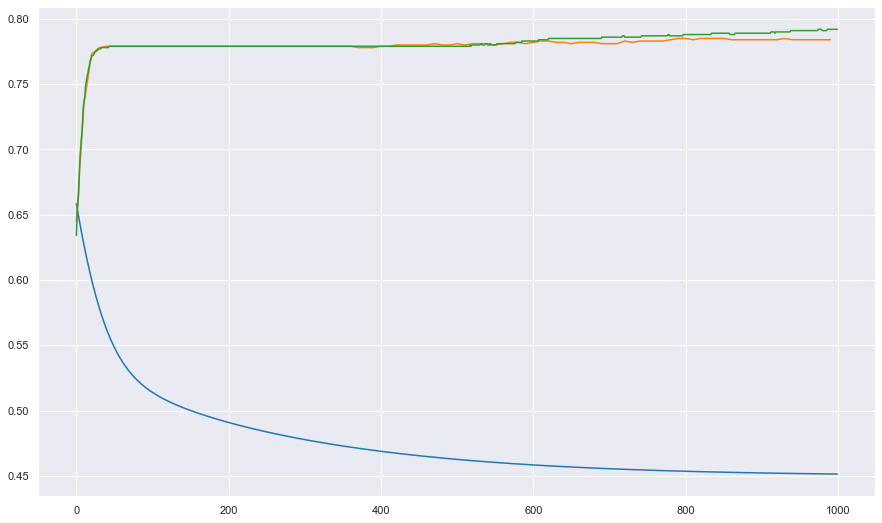

In [46]:
config = get_config(res, X_train.shape[1], epochs=1000, lr=0.001)
model = Model(cfg=config)
res_ll = train_model(model, X_train, X_test, y_train, y_test)

array(0.7060614, dtype=float32)